In [1]:
import os
import matplotlib.pyplot as plt
import cv2
import re

from PIL import Image, ImageDraw, ImageOps
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, activations
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split

import numpy as np
from numpy import asarray

from tinymlgen import port


from utils.preprocessing import preprocessImage
from utils.grad_cam import get_img_array, make_gradcam_heatmap, save_and_display_gradcam
from utils.image_display import imageDisplay
from utils.transform_data import transformData


ModuleNotFoundError: No module named 'utils.transform_predictions'

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1.keras.backend import set_session
from tensorflow.compat.v1 import Session

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9 # fraction of memory
config.gpu_options.visible_device_list = "0"
config.gpu_options.allow_growth = True

set_session(Session(config=config))

# Parameters
The following cell of code is the "control panel" for the rest of the notebook. Here, all preprocessing steps are determined.

In [ ]:
imageFolders = "../Bilder/Manometer/Manometer0711 Labeled"


#Preprocessing
resize_image = False
new_size = (160, 120)
grey_scale = True
rgb_or_grey = 3
normalize_image = False
thresholding = False
erosion = False
kernel = np.ones((2, 2), np.uint8)
cut_image = False
turn_image = False

#Scaling
min_max = True
z_score = False

min_max_labels = False
z_score_labels = False

#Training
batch_size = 16
epochs = 150

if resize_image == True:
    new_size = (160, 120)
    

if grey_scale == True:
    rgb_or_grey = 1

# Data Import

In [ ]:
preprocessImage = preprocessImage()

In [ ]:
#Load in Images and Clean DataFrame
images, labels = preprocessImage.load_images(imageFolders, False, grey_scale, resize_image, new_size, normalize_image, thresholding, erosion, kernel, cut_image, turn_image=turn_image)

imageFolderPath: ../Bilder/Manometer/Manometer0711 labeled - Kopie
Load in Data with Values 0
Load in Data with Values 0.5
Load in Data with Values 1
Load in Data with Values 1.5
Load in Data with Values 10
Load in Data with Values 2
Load in Data with Values 2.5
Load in Data with Values 3
Load in Data with Values 3.5
Load in Data with Values 4
Load in Data with Values 4.5
Load in Data with Values 5
Load in Data with Values 5.5
Load in Data with Values 6
Load in Data with Values 6.5
Load in Data with Values 7
Load in Data with Values 7.5
Load in Data with Values 8
Load in Data with Values 8.5
Load in Data with Values 9
Load in Data with Values 9.5


In [ ]:
#Reshape images
images = images.reshape(len(labels), new_size[1], new_size[0], rgb_or_grey)

#Create Train-/ Test Split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, shuffle=True, random_state=3)
print(X_train.shape)

(840, 120, 160, 1)


In [ ]:
#Create Scaler
transformer = transformData()

#Calculate Params for Train Data Z-Score
mean_value, standard_deviation = transformer.calc_standard_deviation_mean(X_train)

min_value, max_value = transformer.calc_min_max(X_train)

#Scale Train Data
if min_max == True:
    X_train = transformer.scale_min_max(X_train, min_value, max_value)
    X_test = transformer.scale_min_max(X_test, min_value, max_value)

if z_score == True:
    X_train = transformer.scale_z_score(X_train, mean_value, standard_deviation)
    X_test = transformer.scale_z_score(X_test, mean_value, standard_deviation)

#Calculate Params for Labels Z-Score
mean_value_labels, standard_deviation_labels = transformer.calc_standard_deviation_mean(y_train)

min_labels, max_labels = transformer.calc_min_max(y_train)

#Scale Target Data
if min_max_labels == True:
    y_train = transformer.scale_min_max(y_train, min_labels, max_labels)
    y_test = transformer.scale_min_max(y_test, min_labels, max_labels)

if z_score_labels == True:
    y_train = transformer.scale_z_score(y_train, mean_value_labels, standard_deviation_labels)
    y_test = transformer.scale_z_score(y_test, mean_value_labels, standard_deviation_labels)



# Image Generator

In [ ]:
# Use image data generator for data augmentation and rescaling
train_generator = ImageDataGenerator(height_shift_range=0.05, width_shift_range=0.05, zoom_range=0.05)
train_iterator = train_generator.flow(X_train,
                                      y_train,
                                      batch_size = batch_size,
                                      shuffle = True)

validation_iterator = train_generator.flow(X_test,
                                      y_test,
                                      batch_size = batch_size,
                                      shuffle = True)

## Display Images


Images appear Green due to the Array Matplotlib is expecting. Images are Grey Scaled in truth, if the images appear in a greenish colour

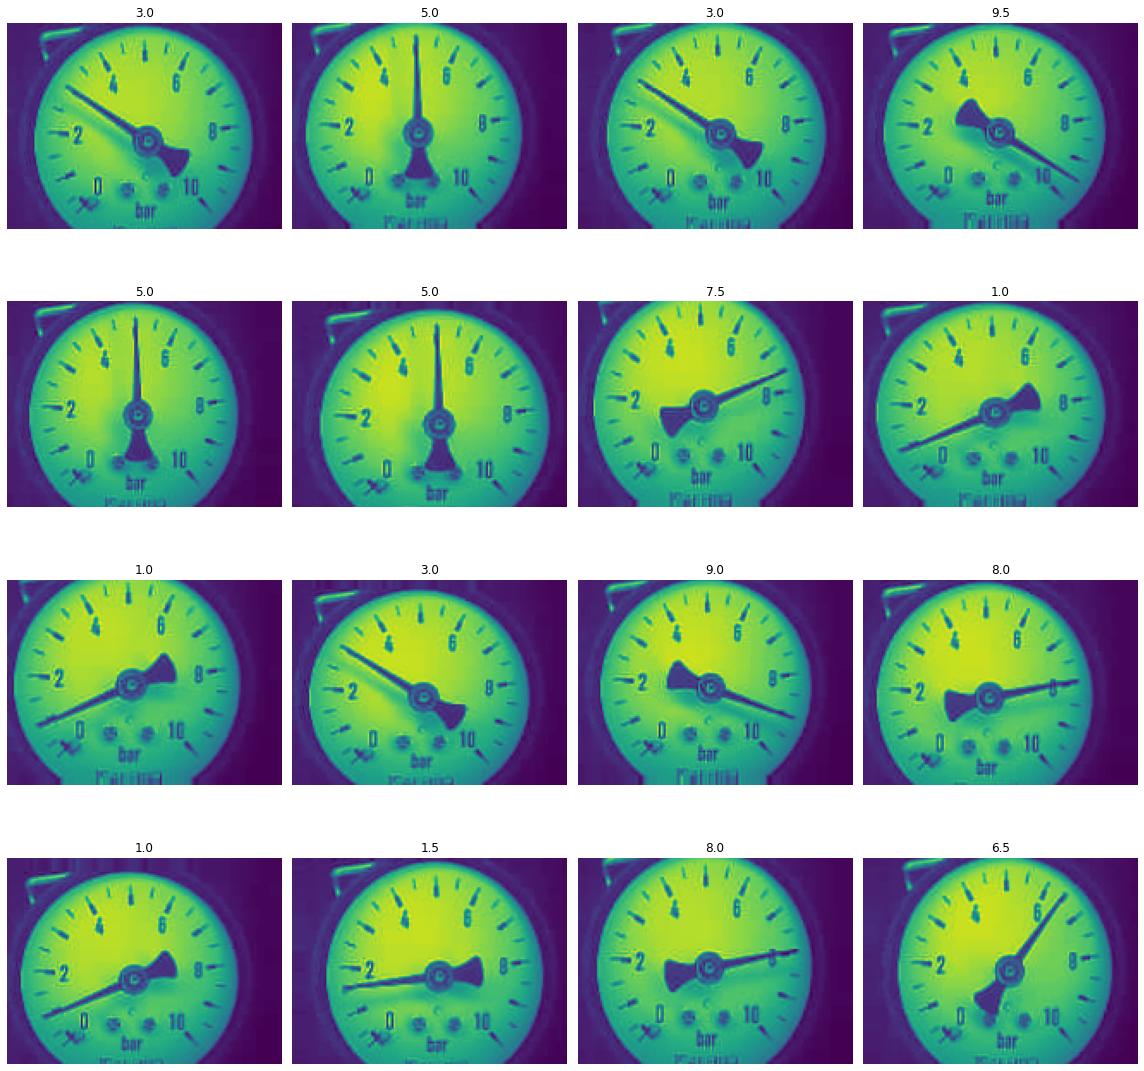

In [ ]:
# Generate graphics
images_test, labels_test = train_iterator.next()

imageDisplay(images_test, labels_test, grey_scale)

# Define Callbacks

In [ ]:
prevent_overfitting = keras.callbacks.EarlyStopping(monitor="val_loss", patience = 5, restore_best_weights=True, verbose=1)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, min_delta=0.0001, verbose=1, factor=0.5)

# Define Model

In [ ]:
def cnn_model(av="relu"):
    model = keras.Sequential([
        layers.InputLayer(input_shape=(new_size[1], new_size[0], rgb_or_grey)),
        layers.Conv2D(filters=128, kernel_size=3, activation=av, data_format='channels_last'),
        layers.Conv2D(filters=128, kernel_size=3, activation=av, data_format='channels_last'),
        layers.Conv2D(filters=128, kernel_size=3, activation=av, data_format='channels_last'),
        layers.Conv2D(filters=128, kernel_size=3, activation=av, data_format='channels_last'),
        layers.MaxPool2D(),
        layers.Conv2D(filters=128, kernel_size=3, activation=av, data_format='channels_last'),
        layers.Conv2D(filters=128, kernel_size=3, activation=av, data_format='channels_last'),
        layers.Conv2D(filters=128, kernel_size=3, activation=av, data_format='channels_last'),
        layers.Conv2D(filters=128, kernel_size=3, activation=av, data_format='channels_last'),
        layers.MaxPool2D(),
        layers.Conv2D(filters=128, kernel_size=3, activation=av, data_format='channels_last'),
        layers.Conv2D(filters=128, kernel_size=3, activation=av, data_format='channels_last'),
        layers.Conv2D(filters=128, kernel_size=3, activation=av, data_format='channels_last'),
        layers.Conv2D(filters=128, kernel_size=3, activation=av, data_format='channels_last'),
        layers.MaxPool2D(),


        layers.Flatten(),

        layers.Dense(1024, activation=av),
        layers.Dense(1024, activation=av),
        layers.Dense(1024, activation=av),
        layers.Dense(1024, activation=av),
        layers.Dense(1024, activation=av),
        layers.Dense(1024, activation=av),
        
        layers.Dense(1, activation=av),
    ])    
    optimizer = keras.optimizers.Adam(learning_rate=0.00001)

    model.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                  optimizer=optimizer)
    
    
    model.summary()
    
    return model

model = cnn_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 118, 158, 128)     1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 116, 156, 128)     147584    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 114, 154, 128)     147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 152, 128)     147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 76, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 54, 74, 128)       147584    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 52, 72, 128)       1

# Train Model

In [ ]:
train_data = X_train.reshape(-1, 120, 160)
test_data = X_test.reshape(-1,120,160)

In [ ]:
def train_model(model):
    print("Training {}".format(model.name))
    history = model.fit(train_iterator,
                    batch_size = batch_size,
                    epochs = 300,
                    validation_data = validation_iterator,
                    shuffle = True,
                    callbacks=[prevent_overfitting])
    
    return history, model

In [ ]:
#Train Model
history_1 = train_model(model)

Training sequential
Epoch 1/300
53/53 [==============================] - 49s 231ms/step - loss: 4.7482 - val_loss: 3.0124
Epoch 2/300
53/53 [==============================] - 8s 158ms/step - loss: 2.6441 - val_loss: 2.7433
Epoch 3/300
53/53 [==============================] - 11s 200ms/step - loss: 2.6355 - val_loss: 2.8117
Epoch 4/300
53/53 [==============================] - 8s 157ms/step - loss: 2.6361 - val_loss: 2.6711
Epoch 5/300
53/53 [==============================] - 9s 173ms/step - loss: 2.5957 - val_loss: 2.7370
Epoch 6/300
53/53 [==============================] - 15s 281ms/step - loss: 2.5941 - val_loss: 2.7075
Epoch 7/300
53/53 [==============================] - 14s 262ms/step - loss: 2.5367 - val_loss: 2.5064
Epoch 8/300
53/53 [==============================] - 13s 241ms/step - loss: 2.2291 - val_loss: 1.9161
Epoch 9/300
53/53 [==============================] - 12s 237ms/step - loss: 1.1287 - val_loss: 0.5523
Epoch 10/300
53/53 [==============================] - 13s 239ms/s

# Validation

In [ ]:
imageFoldersValidation = "../Bilder/Manometer/Blindset final test"

#Load in Images and Clean DataFrame
validation_images, validation_labels = preprocessImage.load_images(imageFoldersValidation, True, grey_scale, False, new_size, normalize_image, thresholding, erosion, kernel, cut_image, turn_image)

validation_images = validation_images.reshape(len(validation_labels), new_size[1], new_size[0], rgb_or_grey)

#Scale Blind Test Set
if min_max == True:
    validation_images = transformer.scale_min_max(validation_images, min_value, max_value)

if z_score == True:
    validation_images = transformer.scale_z_score(validation_images, mean_value, standard_deviation)

#Create Generator
blind_validation_iterator = train_generator.flow(validation_images,
                                                validation_labels,
                                                batch_size = batch_size, #len(y_train),
                                                shuffle = True)


validation_x_images, validation_y_labels = blind_validation_iterator.next()

imageFolderPath: ../Bilder/Manometer/Blindset final test


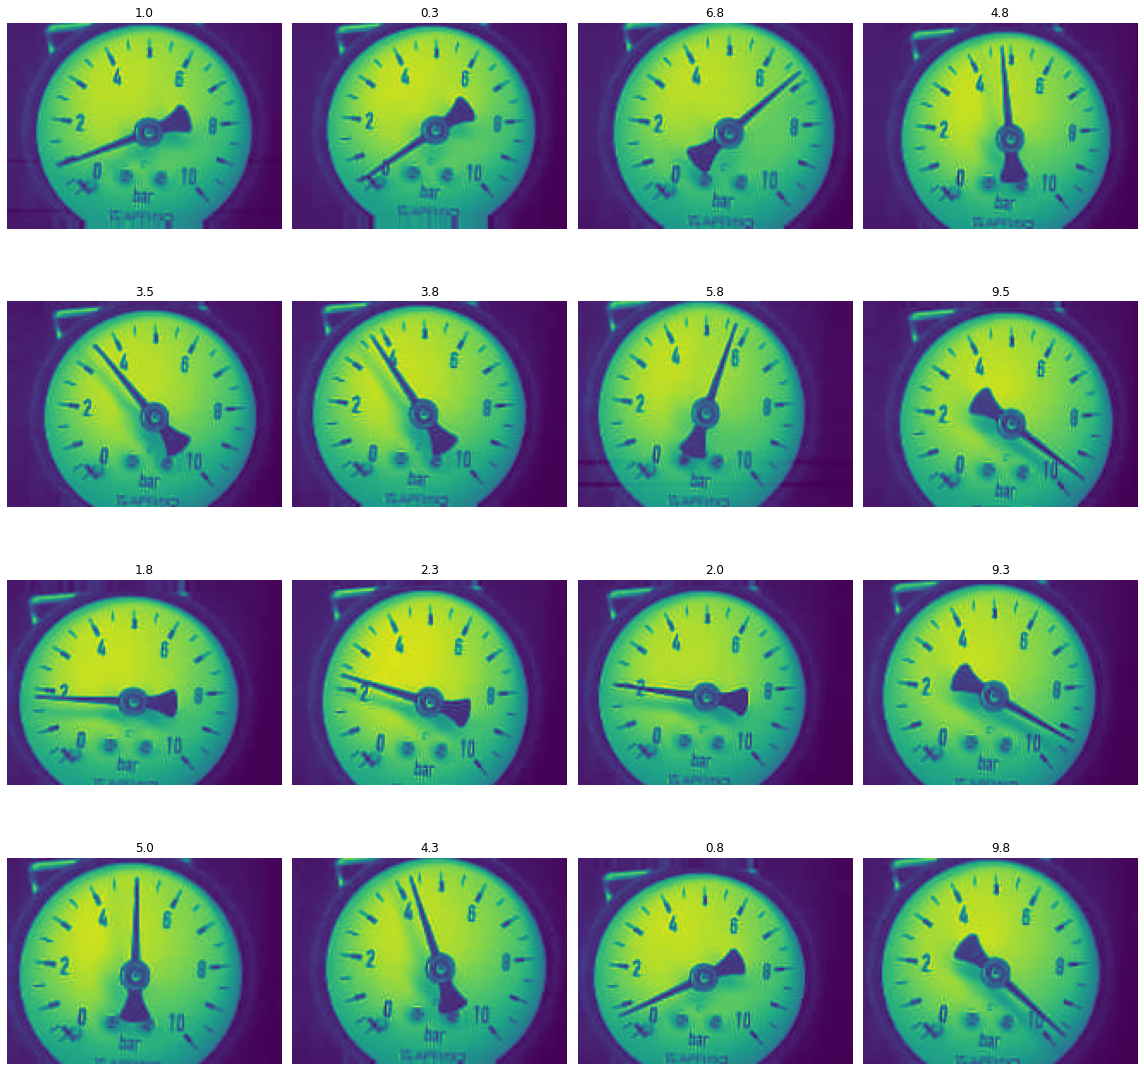

In [ ]:
imageDisplay(validation_x_images, validation_y_labels, grey_scale)

In [ ]:
prediction_transformer = transformPredictions()

In [ ]:
predictions=model.predict(validation_images)
errors = mean_absolute_error(validation_labels, predictions)

errors

0.23227265433567323

In [ ]:

predictions

array([[ 0.16306186],
       [ 0.7767024 ],
       [ 0.77668923],
       [ 0.        ],
       [ 1.3033903 ],
       [ 1.6320739 ],
       [ 1.958342  ],
       [ 0.9573456 ],
       [10.357184  ],
       [ 2.6499012 ],
       [ 2.7193146 ],
       [ 3.042513  ],
       [ 2.1675136 ],
       [ 3.5598052 ],
       [ 3.6752448 ],
       [ 3.9135602 ],
       [ 3.2193546 ],
       [ 4.526002  ],
       [ 4.7226877 ],
       [ 5.0026536 ],
       [ 4.2734733 ],
       [ 5.492792  ],
       [ 5.902062  ],
       [ 6.0722537 ],
       [ 5.2425876 ],
       [ 6.615778  ],
       [ 6.831121  ],
       [ 7.066174  ],
       [ 6.321955  ],
       [ 7.525152  ],
       [ 7.70973   ],
       [ 8.027378  ],
       [ 7.4396706 ],
       [ 8.635482  ],
       [ 8.6389475 ],
       [ 8.886791  ],
       [ 8.316773  ],
       [ 9.558161  ],
       [ 9.9803705 ],
       [10.219364  ],
       [ 9.238015  ]], dtype=float32)

In [ ]:
if min_max_labels:
    predictions = (predictions )*(max_labels - min_labels)+ min_labels
if z_score_labels:
    predictions = predictions  * standard_deviation_labels+ mean_value_labels

In [ ]:
errors = mean_absolute_error(validation_labels, predictions)


In [ ]:
errors

0.23227265433567323

In [ ]:
dict = {}
for A, B in zip(validation_labels, predictions):
    dict[A] = B[0]


In [ ]:
dict

{0.3: 0.16306186,
 0.5: 0.7767024,
 0.8: 0.77668923,
 0.0: 0.0,
 1.3: 1.3033903,
 1.5: 1.6320739,
 1.8: 1.958342,
 1.0: 0.9573456,
 10.0: 10.357184,
 2.3: 2.6499012,
 2.5: 2.7193146,
 2.8: 3.042513,
 2.0: 2.1675136,
 3.3: 3.5598052,
 3.5: 3.6752448,
 3.8: 3.9135602,
 3.0: 3.2193546,
 4.3: 4.526002,
 4.5: 4.7226877,
 4.8: 5.0026536,
 4.0: 4.2734733,
 5.3: 5.492792,
 5.5: 5.902062,
 5.8: 6.0722537,
 5.0: 5.2425876,
 6.3: 6.615778,
 6.5: 6.831121,
 6.8: 7.066174,
 6.0: 6.321955,
 7.3: 7.525152,
 7.5: 7.70973,
 7.8: 8.027378,
 7.0: 7.4396706,
 8.3: 8.635482,
 8.5: 8.6389475,
 8.8: 8.886791,
 8.0: 8.316773,
 9.3: 9.558161,
 9.5: 9.9803705,
 9.8: 10.219364,
 9.0: 9.238015}

In [ ]:
model.save("model_simple.h5")

In [ ]:
model = tf.keras.models.load_model('model_simple.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk

open("testmodel.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Jonas\AppData\Local\Temp\tmpp_o894f_\assets


82035152

In [ ]:
c_code = port(model, pretty_print=True)


file= open("model.h","w")
file.write(c_code)
file.close()

INFO:tensorflow:Assets written to: C:\Users\Jonas\AppData\Local\Temp\tmp122fuog_\assets


INFO:tensorflow:Assets written to: C:\Users\Jonas\AppData\Local\Temp\tmp122fuog_\assets


In [ ]:
image_num = len(validation_labels)-1

pls = validation_images[image_num].reshape(1, 160, 120,1)



preds = []

interpreter = tf.lite.Interpreter(model_path="testmodel.tflite")
interpreter.allocate_tensors()

for element in range(len(validation_labels)):
    
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_data = validation_images[element].reshape(1, 120, 160, 1)#.flatten()
    input_data = np.float32(input_data)
    interpreter.set_tensor(input_details[0]['index'], input_data)

    predictions=interpreter.invoke()
    
    #Rescale Targets if scaled for training
    #predictions=transformer.rescale_z_score(predictions, mean_value_labels, standard_deviation_labels)
    #predictions = prediction_transformer.transform_predictions(predictions, 0, 10)

    output_data = interpreter.get_tensor(output_details[0]['index'])

    preds.append(output_data[0])


#Create Dictionary to Display Results
dict = {"True Value":"Predction"}
for A, B in zip(validation_labels, preds):
    dict[A] = B[0]

dict


{'True Value': 'Predction',
 0.3: 0.16301551,
 0.5: 0.77663577,
 0.8: 0.77663577,
 0.0: 0.0,
 1.3: 1.303737,
 1.5: 1.6319441,
 1.8: 1.9583826,
 1.0: 0.9576578,
 10.0: 10.357925,
 2.3: 2.6495032,
 2.5: 2.719548,
 2.8: 3.0422988,
 2.0: 2.1673229,
 3.3: 3.5596762,
 3.5: 3.6750505,
 3.8: 3.91338,
 3.0: 3.2188644,
 4.3: 4.5256314,
 4.5: 4.7225337,
 4.8: 5.0025835,
 4.0: 4.272777,
 5.3: 5.492934,
 5.5: 5.9019074,
 5.8: 6.072214,
 5.0: 5.242425,
 6.3: 6.615907,
 6.5: 6.831459,
 6.8: 7.065948,
 6.0: 6.3218017,
 7.3: 7.525526,
 7.5: 7.7095876,
 7.8: 8.027761,
 7.0: 7.4404693,
 8.3: 8.636533,
 8.5: 8.639741,
 8.8: 8.8876505,
 8.0: 8.316861,
 9.3: 9.5577,
 9.5: 9.980727,
 9.8: 10.220502,
 9.0: 9.238692}

In [ ]:
preds

[array([0.16301551], dtype=float32),
 array([0.77663577], dtype=float32),
 array([0.77663577], dtype=float32),
 array([0.], dtype=float32),
 array([1.303737], dtype=float32),
 array([1.6319441], dtype=float32),
 array([1.9583826], dtype=float32),
 array([0.9576578], dtype=float32),
 array([10.357925], dtype=float32),
 array([2.6495032], dtype=float32),
 array([2.719548], dtype=float32),
 array([3.0422988], dtype=float32),
 array([2.1673229], dtype=float32),
 array([3.5596762], dtype=float32),
 array([3.6750505], dtype=float32),
 array([3.91338], dtype=float32),
 array([3.2188644], dtype=float32),
 array([4.5256314], dtype=float32),
 array([4.7225337], dtype=float32),
 array([5.0025835], dtype=float32),
 array([4.272777], dtype=float32),
 array([5.492934], dtype=float32),
 array([5.9019074], dtype=float32),
 array([6.072214], dtype=float32),
 array([5.242425], dtype=float32),
 array([6.615907], dtype=float32),
 array([6.831459], dtype=float32),
 array([7.065948], dtype=float32),
 array(

In [ ]:

errors = mean_absolute_error(validation_labels, preds)
#errors = mean_squared_error(validation_labels[16:], predictions[16:])

errors

0.23236178872061938